# PESTPP-GLM

In this notebook, we will run PESTPP-GLM in standard parameter estimation mode and regularization mode.  In both cases, we will use the baked-in bayes-linear posterior monte carlo analysis to get posterior forecast PDFs.  We will use the prior monte carlo outputs as the prior forecast PDF.

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size']=12
import flopy
import pyemu


flopy is installed in /Users/jeremyw/Dev/gw1876/activities_2day_mfm/notebooks/flopy


In [2]:
t_d = "template"
m_d = "master_glm"

In [3]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
gr_sy3,gr_sy3,log,705,0,0.243038,-0.60206,0.211275
cn_prsity7,cn_prsity7,log,1,0,0.176091,-0.30103,0.11928
strk,strk,log,40,0,2,-2,1
cn_strt6,cn_strt6,log,1,0,0.0211893,-0.0222764,0.0108664
cn_strt7,cn_strt7,log,1,0,0.0211893,-0.0222764,0.0108664
pp_sy2,pp_sy2,log,32,0,0.243038,-0.60206,0.211275
cn_prsity6,cn_prsity6,log,1,0,0.176091,-0.30103,0.11928
cn_vka6,cn_vka6,log,1,0,1,-1,0.5
pp_prsity2,pp_prsity2,log,32,0,0.176091,-0.30103,0.11928
gr_vka5,gr_vka5,log,705,0,1,-1,0.5


### reduce the number of adjustable parameters

This is the painful part: we cant use 10K+ pars because we cant wait around for that many runs and then the linear algebra of factoring a 10k+ by 10K+ matrix is also difficult.  So that means we need to fix a lot a parameters #frownyface

In [4]:
par = pst.parameter_data

In [5]:
# grid-scale pars
gr_pars = par.loc[par.pargp.apply(lambda x: "gr" in x),"parnme"]
par.loc[gr_pars,"partrans"] = "fixed"
pst.npar_adj

719

In [6]:
# these are the sfr conductance parameters - Ive left all 40 adjustable
# but if you uncomment this, it will tie them into 1 parameter effectively
# strk_pars = par.loc[par.pargp=="strk","parnme"]
# p1 = strk_pars.iloc[0]
# par.loc[strk_pars.iloc[1:],"partrans"] = "tied"
# par.loc[strk_pars.iloc[1:],"partied"] = p1
pst.npar_adj

719

In [7]:
par.loc[par.pargp.apply(lambda x: "pp" in x),"pargp"].unique()

array(['pp_hk0', 'pp_hk1', 'pp_hk2', 'pp_prsity0', 'pp_prsity1',
       'pp_prsity2', 'pp_rech0', 'pp_rech1', 'pp_ss0', 'pp_ss1', 'pp_ss2',
       'pp_strt0', 'pp_strt1', 'pp_strt2', 'pp_sy0', 'pp_sy1', 'pp_sy2',
       'pp_vka0', 'pp_vka1', 'pp_vka2'], dtype=object)

Fix the storage pilot points - we still have layer-scale storage pars adjustable

In [8]:
#s_pars = par.loc[par.pargp.apply(lambda x: "pp" in x and ("ss" in x or "sy" in x)),"parnme"]
#par.loc[s_pars,"partrans"] = "fixed"
pst.npar_adj

719

In [9]:
adj_par = par.loc[par.partrans=="log",:]
adj_par.pargp.value_counts().sort_values()

cn_prsity7      1
cn_ss8          1
cn_strt7        1
cn_vka8         1
cn_strt6        1
cn_vka6         1
cn_prsity6      1
cn_ss6          1
cn_vka7         1
cn_hk7          1
cn_strt8        1
cn_sy7          1
cn_rech5        1
cn_hk8          1
cn_prsity8      1
cn_ss7          1
flow            1
cn_sy6          1
cn_sy8          1
cn_hk6          1
cn_rech4        1
welflux         2
welflux_k02     6
drncond_k00    10
pp_prsity0     32
pp_sy2         32
pp_ss2         32
pp_vka2        32
pp_sy0         32
pp_hk1         32
pp_ss0         32
pp_hk2         32
pp_hk0         32
pp_prsity2     32
pp_rech0       32
pp_strt1       32
pp_strt2       32
pp_sy1         32
pp_strt0       32
pp_rech1       32
pp_vka0        32
pp_prsity1     32
pp_ss1         32
pp_vka1        32
strk           40
Name: pargp, dtype: int64

fix the future recharge pilot points, vka in layers 1 and 3 and the initial condition pilot points (we still have layer-scale pars for each of these types)

In [10]:
fi_grps = ["pp_rech1","pp_vka0","pp_vka2","pp_strt0","pp_strt1","pp_strt2"]
par.loc[par.pargp.apply(lambda x: x in fi_grps),"partrans"] = "fixed"
pst.npar_adj

527

Ok, thats better...so lets run PESTPP-GLM.  We will use a single "base parameter" jacobian matrix as the basis for 6 super parameter iterations.  Then we will draw 100 realizations from the FOSM posterior parameter covariance matrix and run those 100 realizations to get the psoterior forecast PDFs

In [11]:
pst.control_data.noptmax = 3
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 3
pst.pestpp_options["num_reals"] = 50 # this is how many ies uses
pst.pestpp_options["parcov"] = "prior_cov.jcb"
pst.write(os.path.join(t_d,"freyberg_pp.pst"))

noptmax:3, npar_adj:527, nnz_obs:14


In [12]:
pyemu.os_utils.start_slaves(t_d,"pestpp-glm","freyberg_pp.pst",num_slaves=20,slave_root=".",
                           master_dir=m_d)

In [13]:
df = df=pd.read_csv(os.path.join(m_d,"freyberg_pp.post.obsen.csv"),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

real_name
16     25.142317
48     96.610784
47    196.376492
30    229.606762
44    263.271863
22    303.080285
19    310.056487
7     333.912635
33    345.965930
41    354.876661
1     408.463563
45    534.371489
34    607.919525
39    612.149378
2     616.962285
8     809.884195
31    825.919864
36    830.734862
9     840.691128
4     867.561910
dtype: float64

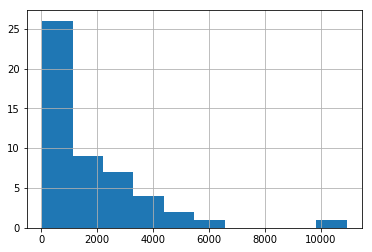

In [14]:
ax = oe.phi_vector.hist()#bins=np.linspace(0,100,20))
oe.phi_vector.sort_values().iloc[:20]

Here we see the distribution of phi values across the 100 posterior realizations.  Should we accept all of these???  The theoretical phi we should accept is number of nonzero obs (14).

To get a "posterior" ensemble, we need to throw out the realizations with large phi - lets just take the 20 best:

In [15]:
oe_pt = oe.loc[oe.phi_vector.sort_values().index[:20],:] #just take the 20 lowest phi realizations

We can also load and plot the FOSM forecast results along side of the ensemble results:

In [16]:
f_df = pd.read_csv(os.path.join(m_d,"freyberg_pp.pred.usum.csv"),index_col=0)
f_df.index = f_df.index.map(str.lower)
f_df

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
fa_hw_19791230,-977.2390,295.32800,-1567.8900,-386.5840,-1065.3500,254.734000,-1574.8100,-555.8800
fa_hw_19801229,-351.2160,409.77000,-1170.7600,468.3240,-83.0591,346.174000,-775.4080,609.2890
fa_tw_19791230,-453.0330,409.35100,-1271.7400,365.6690,-768.4280,178.717000,-1125.8600,-410.9950
fa_tw_19801229,108.9600,506.73200,-904.5040,1122.4200,-82.7267,271.393000,-625.5130,460.0600
hds_00_013_002_000,39.6102,3.96314,31.6840,47.5365,41.1798,0.318847,40.5421,41.8175
hds_00_013_002_001,38.3838,4.05782,30.2681,46.4994,39.6447,0.706586,38.2315,41.0579
part_status,2.0000,0.00000,2.0000,2.0000,2.0000,0.000000,2.0000,2.0000
part_time,907.7020,570.98600,-234.2690,2049.6700,1262.5600,440.591000,381.3790,2143.7400


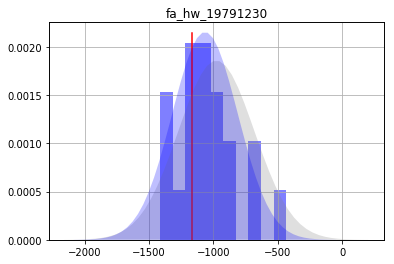

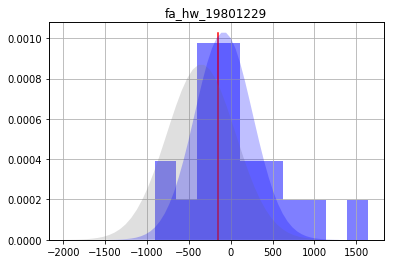

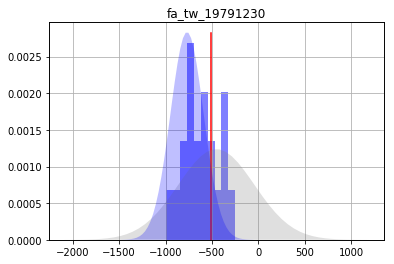

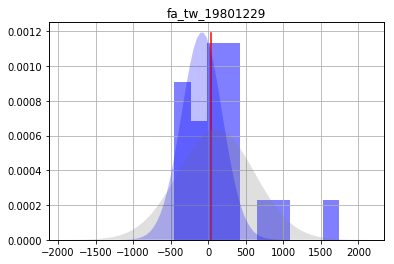

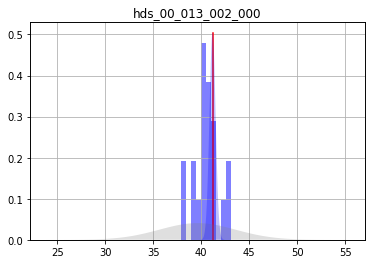

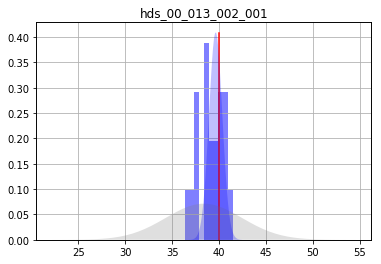

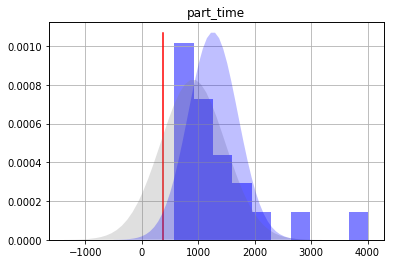

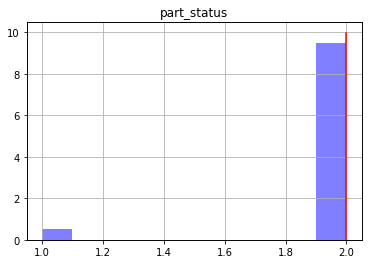

In [17]:
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5,normed=True)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    axt = plt.twinx()
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"prior_mean"],f_df.loc[forecast,"prior_stdev"])
    axt.fill_between(x,0,y,facecolor="0.5",alpha=0.25)
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"post_mean"],f_df.loc[forecast,"post_stdev"])
    axt.fill_between(x,0,y,facecolor="b",alpha=0.25)
    axt.set_ylim(0,axt.get_ylim()[1])
    axt.set_yticks([])
    ax.set_title(forecast)
    plt.show()

### Setup of Tikhonov regularization

Now lets setup and use some formal regularization to bring the final phi up to around 14.  We will use first-order regularization based on the covariance matrix we build earlier:

In [18]:
cov = pyemu.Cov.from_binary(os.path.join(t_d,"prior_cov.jcb"))

new binary format detected...


In [19]:
pyemu.helpers.first_order_pearson_tikhonov(pst,cov)

getting CC matrix
processing


In [20]:
pst.prior_information.head()

,equation,obgnme,pilbl,weight
pilbl,,,,
pcc_1,1.0 * log(dc0000390005) - 1.0 * log(dc0000390006) = 0.0,regul_cc,pcc_1,0.904837
pcc_2,1.0 * log(dc0000390005) - 1.0 * log(dc0000390007) = 0.0,regul_cc,pcc_2,0.818731
pcc_3,1.0 * log(dc0000390005) - 1.0 * log(dc0000390008) = 0.0,regul_cc,pcc_3,0.740818
pcc_4,1.0 * log(dc0000390005) - 1.0 * log(dc0000390009) = 0.0,regul_cc,pcc_4,0.670320
pcc_5,1.0 * log(dc0000390005) - 1.0 * log(dc0000390010) = 0.0,regul_cc,pcc_5,0.606531


In [21]:
shutil.copy2(os.path.join(m_d,"freyberg_pp.jcb"),os.path.join(t_d,"restart_pp.jcb"))


'template/restart_pp.jcb'

In [22]:
pst.pestpp_options["base_jacobian"] = "restart_pp.jcb"
pst.reg_data.phimlim = pst.nnz_obs
pst.reg_data.phimaccept = pst.reg_data.phimlim * 1.1
pst.write(os.path.join(t_d,"freyberg_pp.pst"))

noptmax:3, npar_adj:527, nnz_obs:14


In [23]:
pyemu.os_utils.start_slaves(t_d,"pestpp-glm","freyberg_pp.pst",num_slaves=20,slave_root=".",
                           master_dir=m_d)

In [24]:
df = df=pd.read_csv(os.path.join(m_d,"freyberg_pp.post.obsen.csv"),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

real_name
16     158.641168
48     198.054854
19     220.581275
45     249.971990
7      295.967588
46     365.560372
30     412.222279
44     415.910991
38     416.580172
47     426.089192
41     443.122798
2      461.704473
8      507.139324
1      637.120829
17     688.400904
29     720.689601
22     824.461560
9      847.839389
12     973.938262
18    1089.504943
dtype: float64

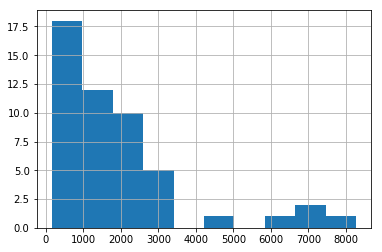

In [25]:
ax = oe.phi_vector.hist()#bins=np.linspace(0,100,20))
oe.phi_vector.sort_values().iloc[:20]

Same as before, to get a "posterior" ensemble, we need to throw out the realizations with large phi - lets just take the 20 best:

In [26]:
oe_pt = oe.loc[oe.phi_vector.sort_values().index[:20],:] 

In [27]:
f_df = pd.read_csv(os.path.join(m_d,"freyberg_pp.pred.usum.csv"),index_col=0)
f_df.index = f_df.index.map(str.lower)
f_df

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
fa_hw_19791230,-977.2390,295.32800,-1567.8900,-386.5840,-1216.0200,260.359000,-1736.7400,-695.3070
fa_hw_19801229,-351.2160,409.77000,-1170.7600,468.3240,-361.9980,354.547000,-1071.0900,347.0970
fa_tw_19791230,-453.0330,409.35100,-1271.7400,365.6690,-844.1200,180.713000,-1205.5400,-482.6950
fa_tw_19801229,108.9600,506.73200,-904.5040,1122.4200,-123.6460,274.499000,-672.6450,425.3520
hds_00_013_002_000,39.6102,3.96314,31.6840,47.5365,41.0266,0.331155,40.3643,41.6889
hds_00_013_002_001,38.3838,4.05782,30.2681,46.4994,39.5589,0.713937,38.1311,40.9868
part_status,2.0000,0.00000,2.0000,2.0000,2.0000,0.000000,2.0000,2.0000
part_time,907.7020,570.98600,-234.2690,2049.6700,1831.8700,449.783000,932.3080,2731.4400


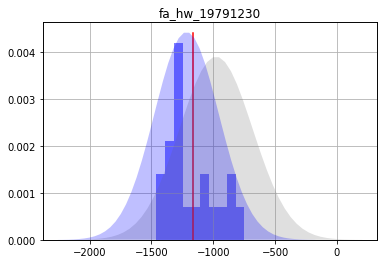

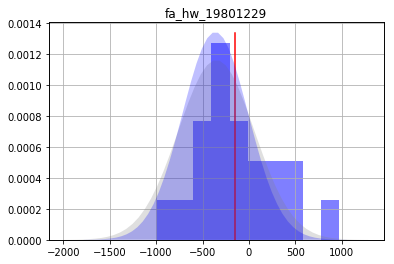

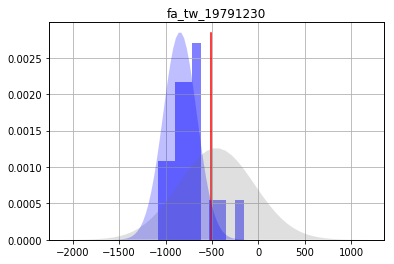

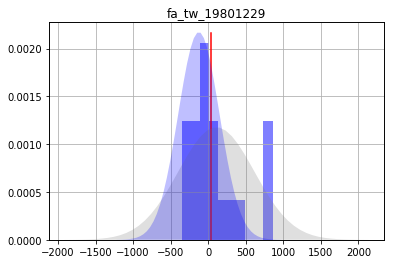

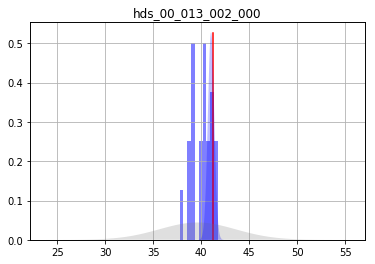

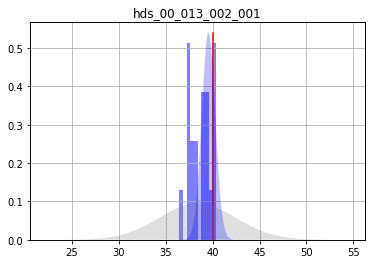

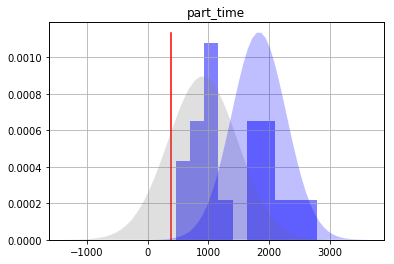

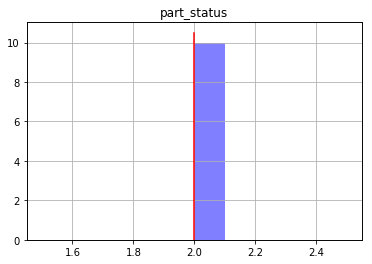

In [28]:
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5,normed=True)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    axt = plt.twinx()
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"prior_mean"],f_df.loc[forecast,"prior_stdev"])
    axt.fill_between(x,0,y,facecolor="0.5",alpha=0.25)
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"post_mean"],f_df.loc[forecast,"post_stdev"])
    axt.fill_between(x,0,y,facecolor="b",alpha=0.25)
    axt.set_ylim(0,axt.get_ylim()[1])
    axt.set_yticks([])
    ax.set_title(forecast)
    plt.show()